In [1]:
import pandas as pd
import numpy as np
import scipy
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random
import seaborn as sns

In [2]:
# read in the entire dataset
master = pd.read_excel('..\Data Cleanup\cleaned_data.xlsx', sheet_name = 'master')

In [3]:
dist_names = ['beta',
              'gamma',
              'lognorm',
              'pearson3',
              'triang',
              'uniform',
              'weibull_min', 
              'weibull_max',
              'truncnorm',
              'truncexpon']

In [4]:
# Data subsets that need to be fit with distributions
loading = master[(master['LoadingUn'] == 'CFU/cm^2') & (master['Loading'] < 150000000)]

In [5]:
params = [
    (loading, "Loading Distribution", 'Loading')
]

C:\Users\PERAZA\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:437: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
C:\Users\PERAZA\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:5823: RuntimeWarning: divide by zero encountered in log
  self._logdelta = np.log(self._delta)
C:\Users\PERAZA\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:5823: RuntimeWarning: invalid value encountered in log
  self._logdelta = np.log(self._delta)
C:\Users\PERAZA\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


      DistName           AIC           LLH
0   truncexpon  1.767258e+05 -8.835991e+04
1    truncnorm           inf          -inf
2  weibull_max  2.206551e+05 -1.103256e+05
3  weibull_min  1.629412e+05 -8.146861e+04
4      uniform  1.794277e+05 -8.971185e+04
5       triang  1.741810e+05 -8.708751e+04
6     pearson3  1.636456e+05 -8.181980e+04
7      lognorm  1.633658e+05 -8.168090e+04
8        gamma           inf          -inf
9         beta  1.729640e+05 -8.647998e+04
weibull_min


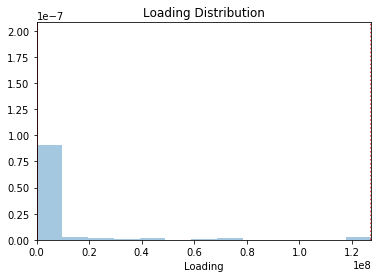

In [6]:
def distributionFitting(data, title, parameter):
    
    # Store efficacy data nicely into y variable
    y = data[parameter].dropna().tolist()
    x = np.linspace(-1, 9, num=1000)
    size = len(y)
    
    # Create the dataframe that will hold the different distribution names and their corresponding AIC
    distFits = pd.DataFrame(columns = ['DistName', 'AIC', 'LLH'])

    # Fit each distribution and calculate and store the AIC
    for distName in dist_names:
        dist = getattr(scipy.stats, distName)

        params = dist.fit(y)

        LLH = dist.logpdf(y,*params).sum()

        if distName == 'truncexpon':
            A = -2*LLH + 2*3
            AIC = A + ((((2*3)**2) + 2*3)/(len(y) - 3 - 1))
        elif distName == 'truncnorm':
            A = -2*LLH + 2*4
            AIC = A + ((((2*4)**2) + 2*4)/(len(y) - 4 - 1))
        elif distName == 'uniform':
            A = -2*LLH + 2*2
            AIC = A + ((((2*2)**2) + 2*2)/(len(y) - 2 - 1))
        elif distName == 'triang':
            A = -2*LLH + 2*3
            AIC = A + ((((2*3)**2) + 2*3)/(len(y) - 3 - 1))
        elif distName == 'pearson3':
            A = -2*LLH + 2*3
            AIC = A + ((((2*3)**2) + 2*3)/(len(y) - 3 - 1))
        elif distName == 'lognorm':
            A = -2*LLH + 2*2
            AIC = A + ((((2*2)**2) + 2*2)/(len(y) - 2 - 1))
        elif distName == 'gamma':
            A = -2*LLH + 2*2
            AIC = A + ((((2*2)**2) + 2*2)/(len(y) - 2 - 1))
        elif distName == 'beta':
            A = -2*LLH + 2*2
            AIC = A + ((((2*2)**2) + 2*2)/(len(y) - 2 - 1))
        else:
            A = -2*LLH + 2*2
            AIC = A + ((((2*2)**2) + 2*2)/(len(y) - 2 - 1))

        rowData = [[distName, AIC, LLH]]
        dat = pd.DataFrame(rowData, columns = ['DistName', 'AIC', 'LLH'])

        distFits = pd.concat([dat, distFits], ignore_index=True)

    # Determine the best fit based on the AICs
    bestAIC = distFits.AIC.min()
    index = distFits.index.get_loc(distFits.index[distFits['AIC'] == bestAIC][0])
    bestDist = distFits.at[index, 'DistName']

    print(distFits)

    print(bestDist)
    
    # Plot the distribution
    fig, ax = plt.subplots()
    
    binSize = round(1 + (3.322 * math.log10(len(y))))
    sns.distplot(data[parameter].dropna(), norm_hist=True, kde_kws={"linestyle":""}, bins=binSize)

    dist = getattr(scipy.stats, bestDist)
    param = dist.fit(y)

    # Get line for each distribution (and scale to match observed data)
    pdf_fitted = dist.pdf(x, *param[:-2], loc=param[-2], scale=param[-1])

    plt.xlim(data[parameter].min() - 0.5, data[parameter].max() + 0.5)
    
    # Add the line to the plot
    plt.plot(x, pdf_fitted, color='red')
    plt.title(title)

    ax.axvline(0, linestyle=":", color="red")
    ax.axvline(data[parameter].max(), linestyle=":", color="red")
    
    plt.show()
    
for p in params:
    distributionFitting(*p)